# Классификация твитов с упоминаниями катастроф

[Kaggle: Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)

**Цель:**

Построить модель, определяющую, упоминается ли в твите настоящая катастрофа.

**План работ:**
1. Загрузка и анализ данных
2. Подготовка данных (очистка твиттов, лемматизация)
3. Обучение LogisticRegression на TF-IDF фичах
4. Fine-tuned BERT

## Импорт библиотек, загрузка train датасета

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
import re
import transformers

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import notebook
from tqdm.auto import tqdm

from wordcloud import WordCloud

In [ ]:
RANDOM_STATE = 2025

In [ ]:
data = pd.read_csv('train.csv')

## Анализ данных

### Общая информация

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


В train датасете 7613 твитов. В столбцах ```keyword``` и ```location``` имеются пропуски.

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(data.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [ ]:
frame = ({'Количество пропусков' : data.isna().sum().sort_values(ascending=False),
        'Доля пропусков, %' : round((data.isna().mean()*100), 2).sort_values(ascending=False)})
pd.DataFrame(frame).sort_values(by='Доля пропусков, %', ascending=False)

,Количество пропусков,"Доля пропусков, %"
location,2533,33.27
keyword,61,0.80
id,0,0.00
text,0,0.00
target,0,0.00


### Целевой признак

In [ ]:
data['target'].value_counts()

,count
target,
0,4342
1,3271


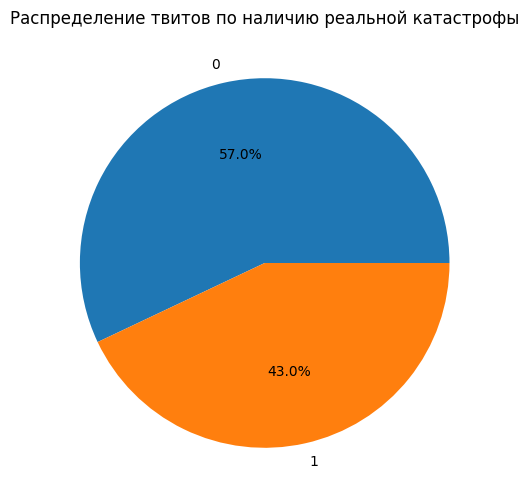

In [ ]:
data['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.title('Распределение твитов по наличию реальной катастрофы')
plt.ylabel('')
plt.show()

Данные несбалансированы, но целевых твиттов все еще достаточно много.

### Location

In [ ]:
data['location'].value_counts()

,count
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
Some pum pum,1
"Paulton, England",1
SEA Server,1


Присутствуют мусорные значения и большое количество (33%) пропусков. В первых версиях модели этот признак использовать не будем.

### Keyword

In [ ]:
data['keyword'].value_counts()

,count
keyword,
fatalities,45
armageddon,42
deluge,42
harm,41
damage,41
...,...
forest%20fire,19
epicentre,12
threat,11


In [ ]:
print(f"Lines without keyword (disaster):\
{data[(data['target'] == 1) & (data['keyword'].isna())].shape[0] / data[(data['target'] == 1)].shape[0]:.2%}")
print(f"Lines without keyword (non disaster):\
{data[(data['target'] == 0) & (data['keyword'].isna())].shape[0] / data[(data['target'] == 0)].shape[0]:.2%}")

Lines without keyword (disaster):1.28%
Lines without keyword (non disaster):0.44%


Процент пропусков небольшой, но ключевым словам потребуется предобработка, если будем использовать их в качестве признака.

### Text (текст твита)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(data['text'].sample(20, random_state=RANDOM_STATE))

,text
3935,RT grant_factory: #grants #funds Weymouth meeting on seawalls and flood grants set for Thursday night Û_ http://t.co/Th2WLilBmo
7317,Man selling WILD MORELS at Ambleside Farmr Mart.Sun.-MUSHROOM forageSECRET IS TO KNOW WHAT TREES they grow under &amp; BEST AFTER FOREST FIRES
6042,ENGLAND EAST COAST. Dogger Bank Westward. 1. Seismic survey in progress by M/V Western Regent towing a 8400 metre long cable within areaÛ_
7175,THIS IS A ONE DIRECTION CONCERT NOT A WAR ZONE WHAT IS THIS #OTRAMETLIFE http://t.co/PtY9HRCUZH
2488,I totally agree. They rape kill destroy and leave land desolate. Action needs to happen before the swarm swells. https://t.co/Twcds433YI
2614,Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/LMWKjsYCgj
3793,Came across this fire video not mine..enjoy..Babes way of saying hi to me while he's in the fire truck??\n#fireman #Û_ http://t.co/V5gTUnwohy
5598,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/2872J5d4HB
4978,Russian #ushanka #winter #military fur hat (xl61-62) with soviet badge LINK:\nhttp://t.co/74YFQxvAK0 http://t.co/KXrEHVt6hL
2431,#tubestrike derailed you? Our #robertwelch cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm


Очистим текст от
- URL
- twitter handle
- html-представлений символов

Хэштеги удалять целиком не будем, т.к. хэштег часто является частью фразы. Для начала попробуем просто удалять символ "#".( ```Russian #ushanka #winter #military fur hat (xl61-62) with soviet badge``` vs  ```Police Officer Wounded ... http://t.co/brE2lGmn7C #ABC #News #AN247```).

In [ ]:
def clean_tweets(tweet):
    ''' Очищает текст твита от URL'ов, mention'ов и лишних символов
    '''
    tweet = tweet.lower()
    tweet = re.sub('@[A-Za-z0-9_]+', ' ', tweet)
    tweet = re.sub(r'http\S+', ' ', tweet)
    tweet = re.sub(r'www\S+', ' ', tweet)
    tweet = re.sub('&amp;', ' ', tweet)
    tweet = re.sub('&gt;', ' ', tweet)
    emoji_pattern = re.compile(
    "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    tweet = emoji_pattern.sub('', tweet)
    tweet = re.sub(r'[^A-Za-z0-9\s]', ' ', tweet)
    return " ".join(tweet.split())

Также нам понадобится лемматизировать твиты для получения TF-IDF фич.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['nlp', 'parser'])

In [ ]:
def lemmatize(sentence):
    ''' Выполняет лемматизацию с использованием spacy
    '''
    sentence = sentence.lower()
    parsed = nlp(sentence)
    text_lemm = " ".join([token.lemma_ for token in parsed if not token.is_stop])
    text_clean = " ".join(re.sub(r'[^a-zA-Z ]', ' ', text_lemm).split())
    return text_clean

In [ ]:
tqdm.pandas()
data['text_clean'] = data['text'].progress_apply(lambda x: clean_tweets(x))

  0%|          | 0/7613 [00:00<?, ?it/s]

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(data[['text', 'text_clean']].sample(20, random_state=RANDOM_STATE))

,text,text_clean
3935,RT grant_factory: #grants #funds Weymouth meeting on seawalls and flood grants set for Thursday night Û_ http://t.co/Th2WLilBmo,rt grant factory grants funds weymouth meeting on seawalls and flood grants set for thursday night
7317,Man selling WILD MORELS at Ambleside Farmr Mart.Sun.-MUSHROOM forageSECRET IS TO KNOW WHAT TREES they grow under &amp; BEST AFTER FOREST FIRES,man selling wild morels at ambleside farmr mart sun mushroom foragesecret is to know what trees they grow under best after forest fires
6042,ENGLAND EAST COAST. Dogger Bank Westward. 1. Seismic survey in progress by M/V Western Regent towing a 8400 metre long cable within areaÛ_,england east coast dogger bank westward 1 seismic survey in progress by m v western regent towing a 8400 metre long cable within area
7175,THIS IS A ONE DIRECTION CONCERT NOT A WAR ZONE WHAT IS THIS #OTRAMETLIFE http://t.co/PtY9HRCUZH,this is a one direction concert not a war zone what is this otrametlife
2488,I totally agree. They rape kill destroy and leave land desolate. Action needs to happen before the swarm swells. https://t.co/Twcds433YI,i totally agree they rape kill destroy and leave land desolate action needs to happen before the swarm swells
2614,Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/LMWKjsYCgj,crackdown 3 destruction restricted to multiplayer crackdown 3 impressed earlier this week with a demonstratio
3793,Came across this fire video not mine..enjoy..Babes way of saying hi to me while he's in the fire truck??\n#fireman #Û_ http://t.co/V5gTUnwohy,came across this fire video not mine enjoy babes way of saying hi to me while he s in the fire truck fireman
5598,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/2872J5d4HB,the latest more homes razed by northern california wildfire abc news
4978,Russian #ushanka #winter #military fur hat (xl61-62) with soviet badge LINK:\nhttp://t.co/74YFQxvAK0 http://t.co/KXrEHVt6hL,russian ushanka winter military fur hat xl61 62 with soviet badge link
2431,#tubestrike derailed you? Our #robertwelch cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm,tubestrike derailed you our robertwelch cutlery offers will get you back on track


In [ ]:
data['text_lemm'] = data['text_clean'].progress_apply(lambda x: lemmatize(x))

  0%|          | 0/7613 [00:00<?, ?it/s]

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(data[['text', 'text_lemm']].sample(20, random_state=RANDOM_STATE))

,text,text_lemm
3935,RT grant_factory: #grants #funds Weymouth meeting on seawalls and flood grants set for Thursday night Û_ http://t.co/Th2WLilBmo,rt grant factory grant fund weymouth meeting seawall flood grant set thursday night
7317,Man selling WILD MORELS at Ambleside Farmr Mart.Sun.-MUSHROOM forageSECRET IS TO KNOW WHAT TREES they grow under &amp; BEST AFTER FOREST FIRES,man sell wild morel ambleside farmr mart sun mushroom foragesecret know tree grow good forest fire
6042,ENGLAND EAST COAST. Dogger Bank Westward. 1. Seismic survey in progress by M/V Western Regent towing a 8400 metre long cable within areaÛ_,england east coast dogger bank westward seismic survey progress m v western regent tow metre long cable area
7175,THIS IS A ONE DIRECTION CONCERT NOT A WAR ZONE WHAT IS THIS #OTRAMETLIFE http://t.co/PtY9HRCUZH,direction concert war zone otrametlife
2488,I totally agree. They rape kill destroy and leave land desolate. Action needs to happen before the swarm swells. https://t.co/Twcds433YI,totally agree rape kill destroy leave land desolate action need happen swarm swell
2614,Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/LMWKjsYCgj,crackdown destruction restrict multiplayer crackdown impressed early week demonstratio
3793,Came across this fire video not mine..enjoy..Babes way of saying hi to me while he's in the fire truck??\n#fireman #Û_ http://t.co/V5gTUnwohy,come fire video enjoy babe way say hi s fire truck fireman
5598,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/2872J5d4HB,late home raze northern california wildfire abc news
4978,Russian #ushanka #winter #military fur hat (xl61-62) with soviet badge LINK:\nhttp://t.co/74YFQxvAK0 http://t.co/KXrEHVt6hL,russian ushanka winter military fur hat xl soviet badge link
2431,#tubestrike derailed you? Our #robertwelch cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm,tubestrike derail robertwelch cutlery offer track


Проверим, не появились ли дубликаты на очищенных текстах.

In [ ]:
data.duplicated(subset=['text_lemm']).sum()

852

In [ ]:
data.drop_duplicates(subset=['text_lemm'], keep='first', inplace=True)

In [ ]:
data.shape

(6761, 7)

In [ ]:
data.head()

,id,keyword,location,text,target,text_clean,text_lemm
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,get send photo ruby alaska smoke wildfires pou...


## Обучение (1 версия - TF-IDF)

Обучим простую логистическую регрессию, используя в качестве признаков TF-IDF.

In [ ]:
data_train, data_valid, target_train, target_valid = train_test_split(
    data.drop('target', axis=1),
    data['target'],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=data['target']
)

In [ ]:
data_train.shape, data_valid.shape

((5408, 6), (1353, 6))

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)

In [ ]:
X_train = tfidf.fit_transform(data_train['text_lemm'])

In [ ]:
X_valid = tfidf.transform(data_valid['text_lemm'])

In [ ]:
logreg = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

In [ ]:
logreg.fit(X_train, target_train)

LogisticRegression(class_weight='balanced', random_state=2025)

In [ ]:
y_pred = logreg.predict(X_valid)

In [ ]:
f1_score(target_valid, y_pred)

0.7346570397111913

### Получение результатов на тестовой выборке

Загрузим тестовые данные и получим предсказание.

In [ ]:
data_test = pd.read_csv('test.csv')

In [ ]:
data_test['text_clean'] = data_test['text'].progress_apply(lambda x: clean_tweets(x))

data_test['text_lemm'] = data_test['text_clean'].progress_apply(lambda x: lemmatize(x))

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [ ]:
X_test = tfidf.transform(data_test['text_lemm'])

In [ ]:
y_test = logreg.predict(X_test)

Сформируем файл submission.

In [ ]:
data_test['target'] = y_test

data_test.head()

result = data_test[['id', 'target']]

result.to_csv('hk_submission_tfidf.csv', index=False)

Получили результат:

Score: ```0.78179```

## Обучение (2 версия - fine-tuned BERT)

Простая модель уже дает неплохой результат.

Попробуем получить результат лучше, используя BERT. Возьмем предобученный bert-base-uncased и проведем fine-tuning.

In [ ]:
BERT_MODEL = 'bert-base-uncased'

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = 2)
tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

Создадим свой кастомный Dataset.

In [ ]:
class LabeledDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
texts = data['text'].values
labels = data['target'].values

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=RANDOM_STATE
)

Создадим DataLoader'ы.

In [ ]:
train_dataset = LabeledDataset(train_texts, train_labels, tokenizer)
val_dataset = LabeledDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

Используем в качестве оптимизатора AdamW.

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
def train_epoch(model, data_loader, optimizer, device):
    ''' Выполняет цикл обучения
    '''
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader):
        batch = {key: value.to(device) for key, value in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [ ]:
def evaluate(model, data_loader, device):
    ''' Рассчитывает loss и accuracy модели
    '''
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            batch = {key: value.to(device) for key, value in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == batch["labels"]).sum().item()

            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / len(data_loader.dataset)
    return avg_loss, accuracy

Запускаем дообучение

In [ ]:
epochs = 1

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1/1
Train Loss: 0.4538, Val Loss: 0.3853, Val Accuracy: 0.8344


In [ ]:
def predict(dataloader, model, device):
    ''' Получает предсказание модели
    '''
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {key: value.to(device) for key, value in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            logits = outputs.logits

            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            predictions.extend(preds)
            probabilities.extend(probs)

    return predictions, probabilities

In [ ]:
y_pred, y_probs = predict(val_loader, model, device)

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
f1_score(val_labels, y_pred)

0.7837837837837838

## Получение результата на тестовой выборке

In [ ]:
data_test = pd.read_csv('test.csv')

In [ ]:
data_test['text_clean'] = data_test['text'].progress_apply(lambda x: clean_tweets(x))

  0%|          | 0/3263 [00:00<?, ?it/s]

In [ ]:
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

In [ ]:
test_texts = data_test['text_clean'].values

test_dataset = TestDataset(test_texts, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
test_pred, test_prob = predict(test_loader, model, device)

  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
data_test['target'] = test_pred

In [ ]:
data_test.head()

,id,keyword,location,text,text_clean,target
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan,1


In [ ]:
result = data_test[['id', 'target']]

In [ ]:
result.to_csv('hk_submission_bert.csv', index=False)

Получили результат:

```Score: 0.83941```